In [1]:
import torchvision
import torchvision.models as models
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

C:\Users\chloe\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
simple_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [3]:
dataset = datasets.ImageFolder(root='data', transform=simple_transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

In [4]:
def compute_mean_std(loader):
    mean = 0.0
    var = 0.0
    total_images_count = 0

    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        var += images.var(2).sum(0)
        total_images_count += batch_samples

    mean /= total_images_count
    std = torch.sqrt(var / total_images_count)
    return mean, std

In [5]:
mean, std = compute_mean_std(dataloader)
print(f'Mean: {mean}')
print(f'Std: {std}')

Mean: tensor([0.7489, 0.6003, 0.5335])
Std: tensor([0.0929, 0.0974, 0.0964])


In [6]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [7]:
dataset.transform = transforms.ToTensor()

total = len(dataset)
train_count = int(0.7 * total)
val_count = int(0.15 * total)
test_count = total - train_count - val_count

train, val, test = random_split(dataset, [train_count, val_count, test_count])

train.dataset.transform = train_transform
val.dataset.transform = val_transform
test.dataset.transform = test_transform

In [8]:
train_loader = DataLoader(train, batch_size=32, shuffle=True)
val_loader = DataLoader(val, batch_size=32, shuffle=False)
test_loader = DataLoader(test, batch_size=32, shuffle=False)

In [9]:
def show_transformed_images(loader):
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels: ',labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 0, 1, 1, 1, 1])


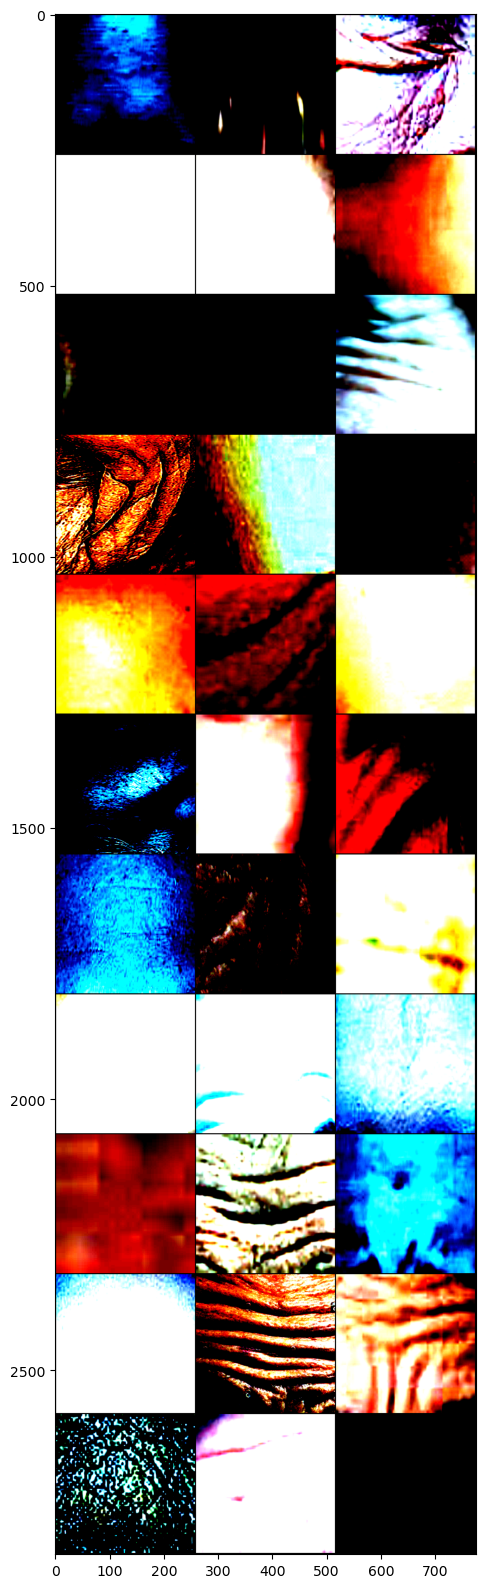

In [10]:
show_transformed_images(train_loader)

In [11]:
def set_device():
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev="cpu"
    return torch.device(dev)

device = set_device()

In [12]:
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(model.fc.in_features, 256, bias=True),
    nn.ReLU(),
    nn.Linear(256, 1, bias=True),
)

C:\Users\chloe\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\chloe\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

In [14]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [15]:
num_epochs = 10

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:  # 0 for no wrinkles and 1 for wrinkles
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels.float())

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    
    # Validation Phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs.squeeze(), labels.float())
            running_val_loss += val_loss.item() * images.size(0)

    val_loss = running_val_loss / len(val_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.3f}, Validation Loss: {val_loss:.3f}')

Epoch [1/10], Train Loss: 0.610, Validation Loss: 0.446
Epoch [2/10], Train Loss: 0.450, Validation Loss: 0.356
Epoch [3/10], Train Loss: 0.414, Validation Loss: 0.525
Epoch [4/10], Train Loss: 0.307, Validation Loss: 0.318
Epoch [5/10], Train Loss: 0.278, Validation Loss: 0.306
Epoch [6/10], Train Loss: 0.289, Validation Loss: 0.569
Epoch [7/10], Train Loss: 0.244, Validation Loss: 0.321
Epoch [8/10], Train Loss: 0.230, Validation Loss: 0.350
Epoch [9/10], Train Loss: 0.189, Validation Loss: 0.427
Epoch [10/10], Train Loss: 0.156, Validation Loss: 0.352


In [16]:
model.eval()
total_loss = 0.0
total_accuracy = 0.0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels.float())
        total_loss += loss.item() * images.size(0)

        # Calculate accuracy
        predictions = outputs.squeeze() > 0.5
        correct = (predictions == labels).float().sum()
        total_accuracy += correct

avg_loss = total_loss / len(test_loader.dataset)
avg_accuracy = total_accuracy / len(test_loader.dataset)
print(f'Test Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}')

Test Loss: 0.4534, Accuracy: 0.8182


In [17]:
torch.save(model.state_dict(), 'wrinkles_model.pth')

In [18]:
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(new_model.fc.in_features, 256, bias=True),
    nn.ReLU(),
    nn.Linear(256, 1, bias=True),
)
new_model.load_state_dict(torch.load('wrinkles_model.pth'))

C:\Users\chloe\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\chloe\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [3]:
img_path = 'wrinklestest.jpeg'
img = Image.open(img_path)

input_tensor = test_transform(img).unsqueeze(0)
new_model.eval()

output = new_model(input_tensor)
prediction = "no wrinkles" if output < 0.5 else "wrinkles"
plt.imshow(img)
plt.axis('off')
plt.show()
print(f'Prediction: {prediction}')

NameError: name 'Image' is not defined